# Adstock Effect & Diminishing Returns <a id='top'></a>

_Using Python in Marketing Analysis | Marketing Data Science_

***

## Table of Contents

* [Introduction](#intro)
* [Import Required Libraries](#import)
* [Load Data](#load)
* [Derive Adstock Rate with Analytical Method](#analytical)
* [Plot](#plot)
* [Prepare Data](#prep)
* [Discover the Adstock Effect Using Neural Network](#nn)
* [Solve with Probabilistic Programming](#prob)
* [Estimate the Adstock and Hill Function Parameters](#params)

## Introduction <a id='intro'></a>

An important question in marketing data science is how advertising affects sales. This problem often comes up as “I spend money on day 1, when will I see the sales/subscriptions go up, and by how much”. The money spend now may take time to have an effect. For example, it might take some time for ads to circulate in the community. The effect of advertising may also carry over from one ads campaign to the next because people remember your products. This kind of effect is called a lag/carryover effect.

Another kind of effect has to do with the diminishing returns on ads. That is to say, spending too much on ads will simply saturate the market and any more money spent won’t drive the sales further. This is called saturation effect.

## Import Required Libraries <a id='import'></a>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(8, 3)})

import torch
import torch.nn as nn

import pyro
import pyro.distributions as dist
pyro.set_rng_seed(1)
pyro.enable_validation(True)
from pyro.infer import MCMC, NUTS
from pyro.nn import PyroModule, PyroSample

[Go to the top](#top)

## Load Data <a id='load'></a>

Read the dataset and load it into a Pandas dataframe.

In [2]:
# Read specific columns
df = pd.read_csv('combined data.csv', usecols=['Date', 'Ad Impressions', 'Direct Visit Clicks'])

# Show df
df

,Date,Ad Impressions,Direct Visit Clicks
0,1/1/21,26779,491
1,1/2/21,27029,474
2,1/3/21,26764,406
3,1/4/21,28494,635
4,1/5/21,32643,580
...,...,...,...
118,4/29/21,1656,752
119,4/30/21,1474,759
120,5/1/21,798,491
121,5/2/21,888,501


In [3]:
# Set date as index
df = df.set_index(pd.DatetimeIndex(df['Date']))
df.drop('Date', axis=1, inplace=True)

# Normalize data into a 0-10 scale
df = 10 * (df - df.min()) / (df.max() - df.min())

# Show df
df

,Ad Impressions,Direct Visit Clicks
Date,,
2021-01-01,0.146368,0.786908
2021-01-02,0.147777,0.668524
2021-01-03,0.146284,0.194986
2021-01-04,0.156030,1.789694
2021-01-05,0.179404,1.406685
...,...,...
2021-04-29,0.004834,2.604457
2021-04-30,0.003808,2.653203
2021-05-01,0.000000,0.786908


[Go to the top](#top)

## Derive Adstock Rate with Analytical Method <a id='analytical'></a>

In [4]:
# Create a function to calculate adstock values
def calc_adstock(ad_data, adstock_rate):
    # Init adstock
    adstock = np.zeros(len(ad_data))
    # Init first adstock value
    adstock[0] = ad_data[0]
    # Loop through the dataset to calculate adstock values
    for i in range(1, len(ad_data)):
        adstock[i] = ad_data[i] + adstock_rate * adstock[i-1]
    return adstock


# Create a function that optimizes adstock and makes a plot
def optimize_adstock(ad_data, clicks):
    # Init a list to keep correlations
    corrs = []
    # Create an array of rates to check for optimization
    rates = np.arange(0, 1.01, 0.01)
    # Init max rate
    rmax = 0
    # Init max correlation
    corrmax = -1
    # Loop through the rates
    for r in rates:
        # Calculate adstock for the specific rate
        x = calc_adstock(ad_data.copy(), r)
        # Get the clicks data
        y = clicks
        # Compute correlation
        corr = np.corrcoef(x, y)[0][1]
        # Append correlation to the list
        corrs.append(corr)
        # Find the maximum correlation
        if corr > corrmax:
            rmax = r
            corrmax = corr
    # Create the plot
    plt.title("Correlation vs. Decay Rate")
    plt.plot(rates, corrs, label="Correlations")
    plt.xlabel("Decay Rates")
    plt.ylabel("Correlations")
    plt.legend()
    plt.show()
    
    print('Found {0} decay rate at maximum correlation coefficient {1}'.format(rmax, corrmax))
    
    return rmax

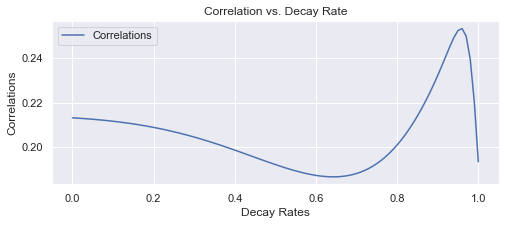

Found 0.96 decay rate at maximum correlation coefficient 0.2533933889330589


In [5]:
# Optimize adstock for our dataset and print the decay rate
rmax = optimize_adstock(ad_data=df['Ad Impressions'], clicks=df['Direct Visit Clicks'])

**Inference**

- Very low correlation

[Go to the top](#top)

## Plot <a id='plot'></a>

In [6]:
# Create the adstock data for the maximum decay rate
df['Ad Impressions After Adstock'] = calc_adstock(ad_data=df['Ad Impressions'], adstock_rate=rmax)
df

,Ad Impressions,Direct Visit Clicks,Ad Impressions After Adstock
Date,,,
2021-01-01,0.146368,0.786908,0.146368
2021-01-02,0.147777,0.668524,0.288290
2021-01-03,0.146284,0.194986,0.423043
2021-01-04,0.156030,1.789694,0.562151
2021-01-05,0.179404,1.406685,0.719069
...,...,...,...
2021-04-29,0.004834,2.604457,32.680848
2021-04-30,0.003808,2.653203,31.377422
2021-05-01,0.000000,0.786908,30.122325


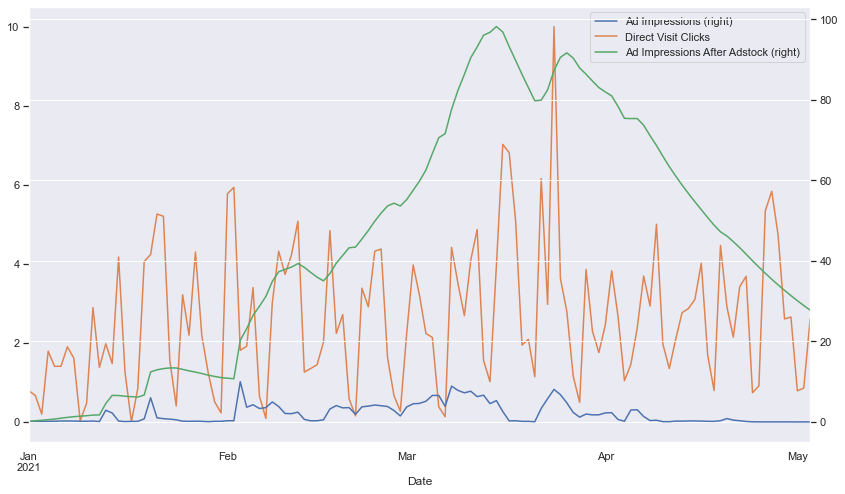

In [7]:
df.plot(secondary_y=['Ad Impressions', 'Ad Impressions After Adstock'], figsize=(14, 8));

[Go to the top](#top)

## Prepare Data <a id='prep'></a>

Another way to deal with it is to recover the adstock kernel from the ad and clicks data. This could be done using deep learning tools such as a neural network. First, we need to prepare/transform the data.

In [8]:
def get_padded_spend(spend, max_lag):
    """
    convert vector of spend/impressions to matrix where
    each column is one element with
    [spend[t], spend[t-1], …, spend[t-max_lag]]
    shape = (day x max_lag)
    """
    X_media = []
    N = len(spend)
    for time_point in range(N):
        unpadded = spend[max([0, time_point-max_lag]):(time_point + 1)]
        pad = [0]*max([0, max_lag + 1 - len(unpadded)])
        X_media.append(unpadded[::-1] + pad[::-1])
    return np.array(X_media)

# Pad ad data
matrix_spend = get_padded_spend(df['Ad Impressions'].to_list(), 5)
# Transform for convolutional neural network
torch_spend = torch.Tensor(df['Ad Impressions'].to_list())
# Transform for fully connected neural network
x_data = torch.Tensor(matrix_spend)
y_data = torch.Tensor(df['Direct Visit Clicks'].to_list())

[Go to the top](#top)

## Discover the Adstock Effect Using Neural Network <a id='nn'></a>

Here we first look at a single layer neural network to for the adstock function. I tried both linear or fully connected (fc) and convolutional (conv) neural network. In both cases, I used pytorch implementation of neural network. The code for this part is shown in the Appendix subsection D.

I trained the model for 5000 iterations. The results shown below are the weights of the neural network used to fit it. The weights should reflect the adstock kernel, which they indeed are.

CPU times: user 1.44 s, sys: 4.43 s, total: 5.87 s
Wall time: 1.06 s


Text(0.5, 1.0, 'single layer perception fitting')

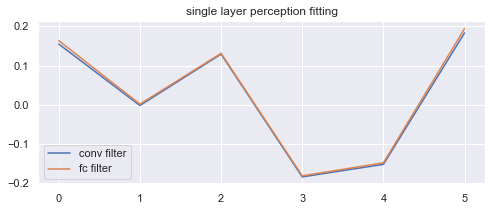

In [9]:
%%time

model = nn.Linear(5+1,1)
model = model.to()
learning_rate = 1e-3
criterion = torch.nn.MSELoss()
optimizer_fc = torch.optim.Adam(model.parameters(), lr=learning_rate)

conv_model = nn.Conv1d(1, 1, 5+1, stride=1)
learning_rate = 1e-3
criterion = torch.nn.MSELoss()
optimizer_conv = torch.optim.Adam(conv_model.parameters(), lr=learning_rate)

def execute_function(model,optimizer,epochs, data_X, data_y,conv=False):
    epoch_loss = []
    count = 0
    if conv:
        data_X = data_X.unsqueeze(0).unsqueeze(0)
    for epoch in range(epochs):
        temp_loss = []
        model.train()
        optimizer.zero_grad()
        result = model(data_X)
        #print(result.shape)
        if conv:
            result = result.squeeze(0).squeeze(0)
        else:
            result = result.squeeze(1)
        loss = criterion(result,data_y)
        loss.backward()
        optimizer.step()
        temp_loss.append(loss.item())
        count += 1
        #print(count)
        epoch_loss.append(np.mean(temp_loss))
    return epoch_loss

loss1 = execute_function(conv_model,optimizer_conv,5000,torch_spend,y_data[5:],conv=True)
loss2 = execute_function(model,optimizer_fc,5000,x_data,y_data)

# to plot this we can get the weights of the models and plot the weights
# note the conv. filter is the flipped kernel due to the notation convention of convolution.
# we will just flip back
# below here is the code plotting

conv_filter = conv_model.weight.squeeze(0).squeeze(0).detach().numpy()[::-1]
np_kernel = model.weight.detach().numpy()
np_kernel = np_kernel.reshape(5+1)
plt.plot(conv_filter,label = 'conv filter')
plt.plot(np_kernel,label='fc filter')
# plt.plot(kernel_carryover/np.sum(kernel_carryover),label = 'ground truth')
plt.legend(loc='best')
plt.title('single layer perception fitting')

[Go to the top](#top)

## Solve with Probabilistic Programming <a id='prob'></a>

In addition to the previous methods, we can use Bayesian inference. The added benefit of doing this is that we get the full probability distribution of the adstock kernels. It provides the ranges and uncertainty estimates of the models.

Sample: 100%|██████████| 1200/1200 [00:09, 128.85it/s, step size=2.15e-01, acc. prob=0.949]

CPU times: user 9.29 s, sys: 48 ms, total: 9.33 s
Wall time: 9.34 s


Text(0, 0.5, 'weight')

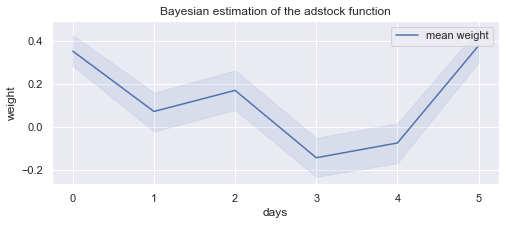

In [10]:
%%time

# first we will specify the model as function
# this is different from Pymc3 which uses with context manager

def bayesian_model_indexing(x_data,y_data,max_lag=5+1):
    # the weights (shape = 11) are sampled independently from 11 normal distribution.
    weight = pyro.sample('weight',dist.Normal(torch.zeros(max_lag),5.0*torch.ones(max_lag)))
    with pyro.plate('data',len(x_data)):
        mean = torch.sum(weight*x_data,dim=1)  # apply adstock kernel to the spend data (dot product)
        pyro.sample('y',dist.Normal(mean,1),obs=y_data) # the result is the sales. subjected to observation


# Then we will call create NUTS and MCMC objects which specify how we will run MCMC
kernel_bayes= NUTS(bayesian_model_indexing)
mcmc_bayes = MCMC(kernel_bayes, num_samples=1000, warmup_steps=200)
mcmc_bayes.run(x_data, y_data) # don't forget to include your data in the run

# we get the traces of MCMC and store as a dictionary 
# we then can use these traces to find means and credible intervals
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc_bayes.get_samples().items()}

# get the means value, and 90% credible interval
mean_weight = np.mean(hmc_samples['weight'],axis=0)
weight_0p1 = np.quantile(hmc_samples['weight'],q=0.1,axis=0)
weight_0p9 = np.quantile(hmc_samples['weight'],q=0.9,axis=0)

# finally we can plot this in Matplotlib
fig, ax = plt.subplots()
ax.plot(mean_weight,label='mean weight')
ax.fill_between([i for i in range(5+1)],weight_0p1,weight_0p9, color='b', alpha=.1)
ax.legend(loc='best')
plt.title('Bayesian estimation of the adstock function')
plt.xlabel('days')
plt.ylabel('weight')

[Go to the top](#top)

## Estimate the Adstock and Hill Function Parameters <a id='params'></a>

Finally, the Bayesian inference could be done in hierarchical manners where the kernel weight is generated from hyper-priors, namely the retention rate, delay rate, etc. This allows us to estimate the parameters such as delay, retention, etc. that govern the spending/sales dynamics. With this approach we will also estimate the dimishing returns.

In [11]:
def bayesian_model_adstock(x_data,y_data,max_lag=5+1,fit_Hill=False):
    lag = torch.tensor(np.arange(0, max_lag + 1))
    # here instead of sampling weights, we will sample the adstock parameters
    # the parameters are sampled independently from normal distribution
    retain_rate = pyro.sample('retain_rate',dist.Uniform(0,1))
    delay = pyro.sample('delay',dist.Normal(1,5))

    # the adstock parameters are used to generate the adstock kernels
    weight = retain_rate**((lag-delay)**2)
    weight = weight/torch.sum(weight)

    # sample the saturation function parameters
    ec50 = pyro.sample('ec50',dist.Normal(0.5,1))
    slope = pyro.sample('Hill slope',dist.Normal(5,2.5))
    beta = pyro.sample('beta',dist.Normal(0,0.5))

    with pyro.plate('data',len(x_data)):
        # apply adstock kernel to spend data
        mean = torch.sum(weight*x_data,dim=1)
        # conditional, do you want to fit saturation function ?
        if fit_Hill:
            response = 1/(1+ (mean/ec50)**-slope)
            response = beta*response
        else:
            response = mean
        # the result is the sales which is subjected to the observation.
        pyro.sample('y', dist.Normal(response,1), obs=y_data)

In [12]:
%%time

kernel_bayes= NUTS(bayesian_model_adstock)
mcmc_bayes = MCMC(kernel_bayes, num_samples=1000, warmup_steps=200)
mcmc_bayes.run(x_data, y_data, max_lag=5, fit_Hill=True)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc_bayes.get_samples().items()}

Sample: 100%|██████████| 1200/1200 [00:34, 34.75it/s, step size=1.18e-01, acc. prob=0.570] 

CPU times: user 34.4 s, sys: 88.6 ms, total: 34.5 s
Wall time: 34.5 s


retain_rate


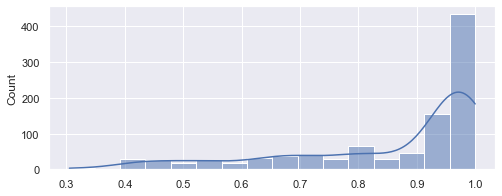

delay


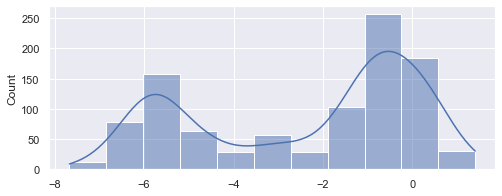

ec50


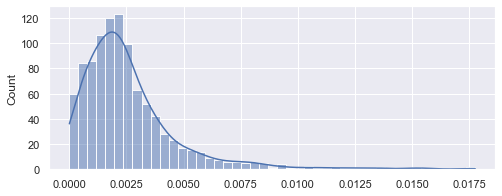

Hill slope


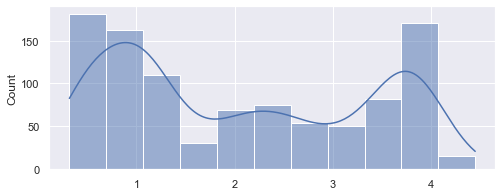

beta


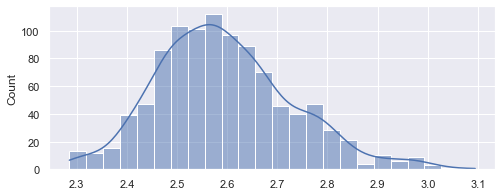

In [13]:
for key, value in hmc_samples.items():
    print(key)
    sns.histplot(value, kde=True)
    plt.show()

[Go to the top](#top)

**Inference**

Look at the kde distributions for each parameter:

* The Adstock effect is carried over from time t to t+1 at the `retain_rate`
* The peak effect can be delayed by the `delay` term
* The half-saturation point is at `ec50`
* The shape parameter is given by the `Hill slope`